In [16]:
!pip install lightgbm

  Using cached lightgbm-3.3.5-py3-none-win_amd64.whl (1.0 MB)


In [1]:
import pandas as pd
import dill
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, mean_squared_error
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
import seaborn
from matplotlib import pyplot as plt

#working with text
from sklearn.feature_extraction.text import TfidfVectorizer

#normalizing data
from sklearn.preprocessing import StandardScaler

#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score

#imputer
from sklearn.impute import SimpleImputer

import sklearn.datasets

In [2]:
df = pd.read_csv('Cancer_Data.csv')
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


In [3]:
df.drop(columns='Unnamed: 32', inplace=True)

In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

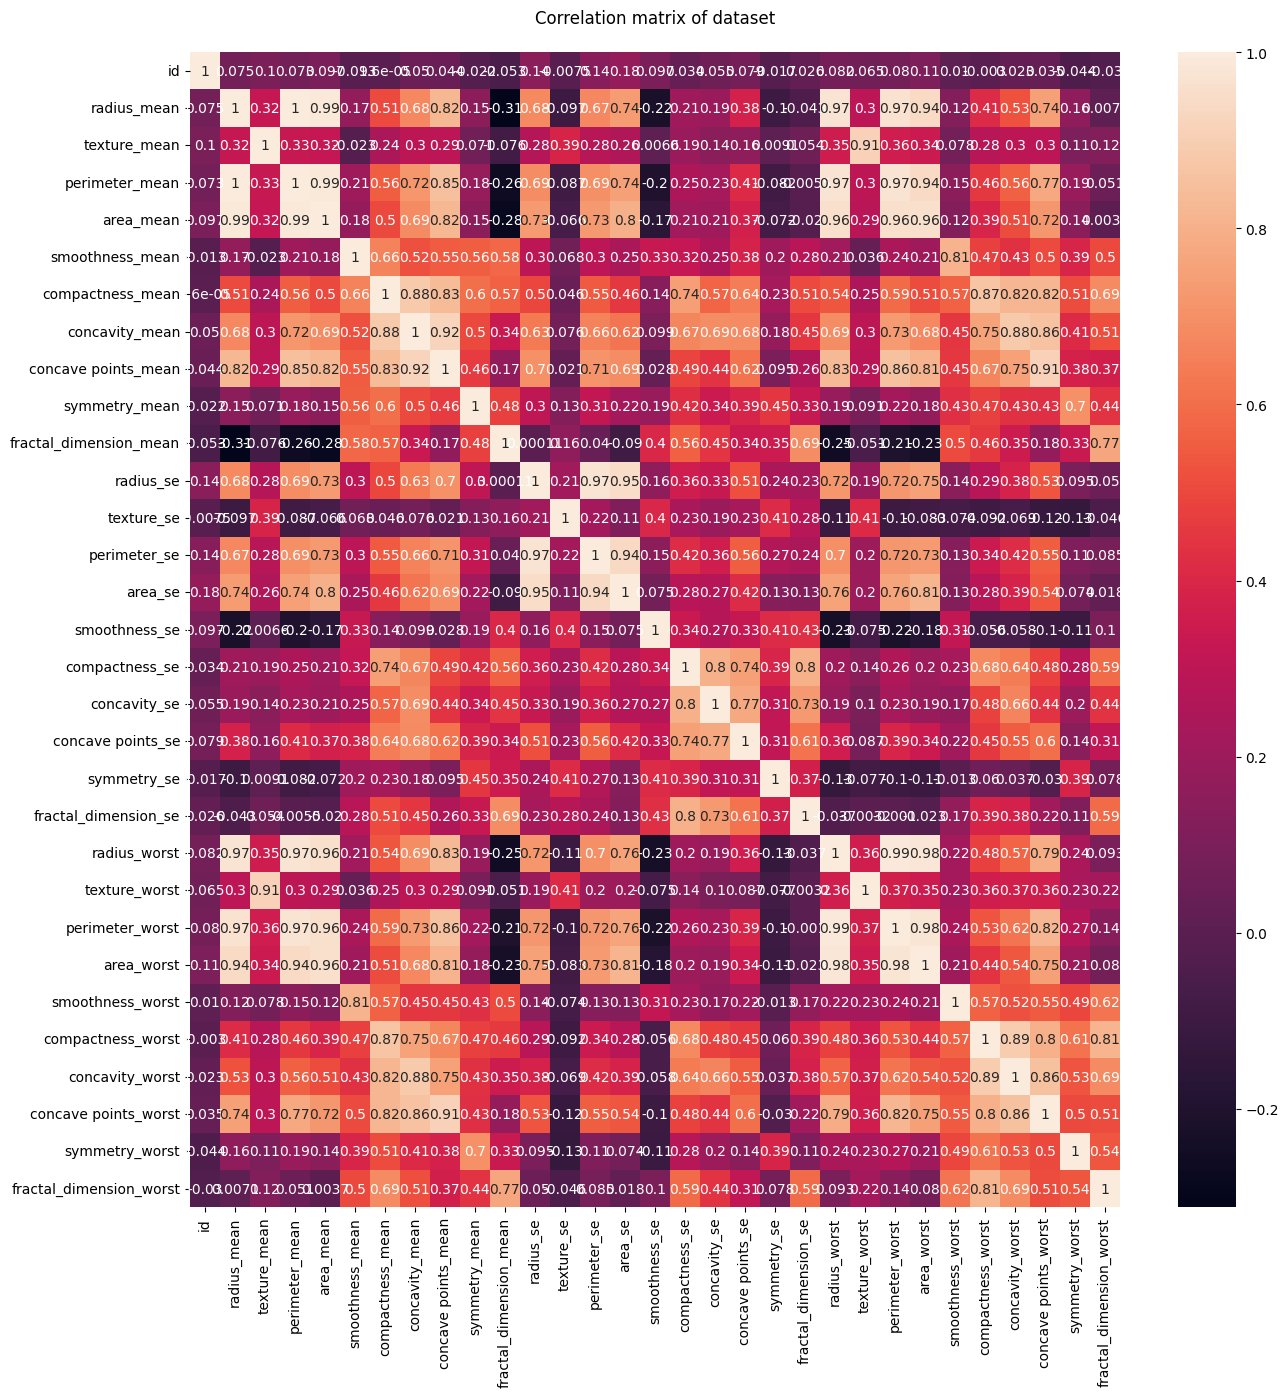

In [12]:
fig = plt.figure(figsize=((15, 15)))
correlation = df.corr()
heatmap = seaborn.heatmap(correlation, annot = True)
heatmap.set(title = "Correlation matrix of dataset\n")  
plt.show()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
target = df['diagnosis']

In [8]:
target = target.map({'M': 1, "B": 0})

In [9]:
df.drop(columns='diagnosis', inplace=True)

In [13]:
plt.rcParams.update({'font.size': 7})

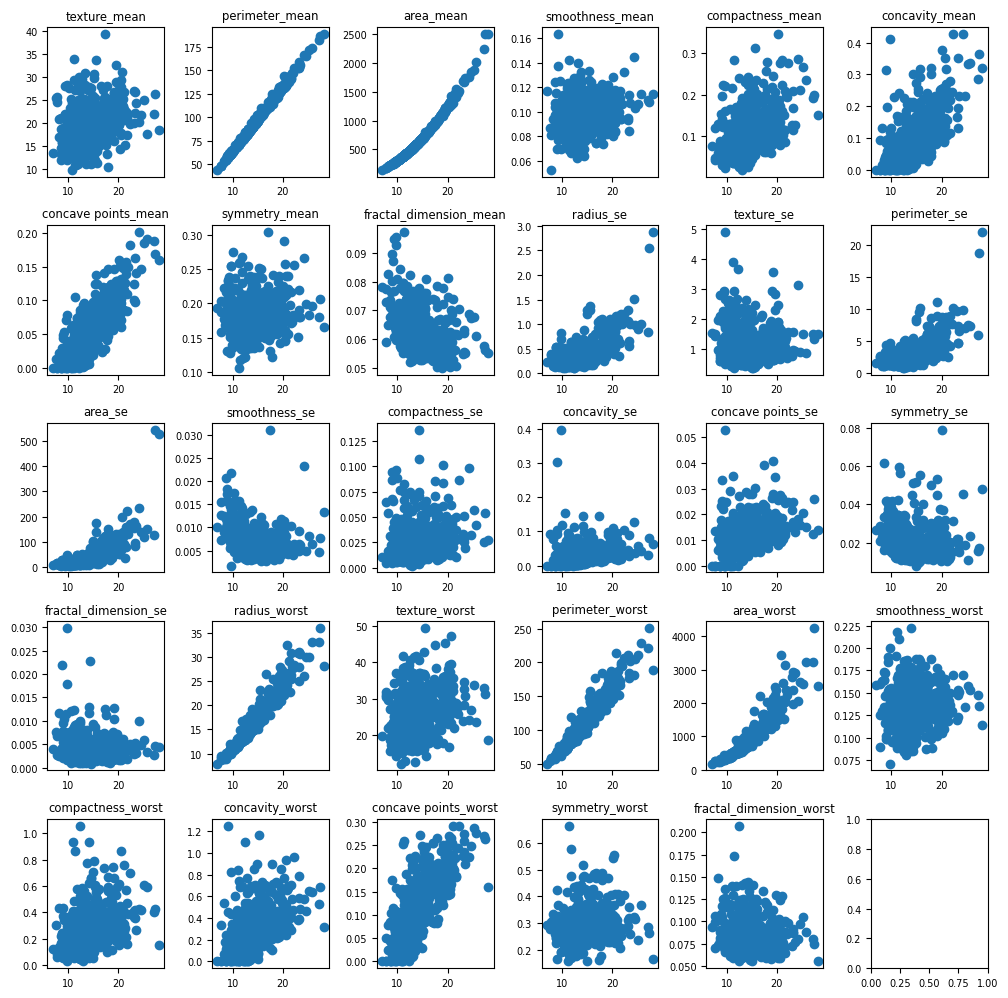

In [14]:
fig, _ = plt.subplots(5, 6)
axes = fig.get_axes()
fig.set_size_inches((10,10))
columns = df.drop(columns=['id', 'radius_mean']).columns
for i, feature in enumerate(columns):    
    axes[i].scatter(df['radius_mean'], df[feature])
    axes[i].set_title(feature)   
fig.tight_layout()

In [15]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.loc[:, self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p=2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index, columns =[self.columns] )
        return B[self.columns]
    
class Division(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = []
    
    def fit(self, X, y=None):
        self.columns = X.columns
        self.new_column = self.columns[0] + '/' + self.columns[1]
        return self
    
    def transform(self, X):
        X[self.new_column] = X.loc[:, self.columns[0]] / X.loc[:, self.columns[1]]
        X.drop(columns=self.columns, inplace=True)
        return X.to_numpy()

In [18]:
numeric_features = ['texture_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'texture_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
division_features = [
    ['radius_mean', 'perimeter_mean'],
    ['radius_mean', 'perimeter_worst'],
    ['radius_mean', 'area_worst'],
    ['radius_mean', 'area_mean'],
    ['radius_mean', 'radius_worst'],
]

In [19]:
final_transformers = []

for feat in numeric_features:
    transformer = Pipeline([
        ('selector', NumberSelector(key=feat)),
        ('scaler', MinMaxScaler()),
    ])
    final_transformers.append((feat, transformer))
for feat_pairs in division_features:
    transformer = Pipeline([
        ('selector', FeatureSelector(column=feat_pairs)),
        ('division', Division()),
    ])
    final_transformers.append(('/'.join(feat_pairs) ,transformer))

feats = FeatureUnion(final_transformers)
model = Pipeline([
    ('feats', feats),
    ('classifier', LGBMClassifier(boosting_type='gbdt',
                                            objective= 'regression',
                                            metric= 'l1',
                                            num_leaves=31,
                                            learning_rate= 0.05,
                                            feature_fraction= 0.9,
                                            bagging_fraction= 0.8,
                                            bagging_freq= 5,
                                            verbose= 0))
])

In [20]:
model

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('texture_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='texture_mean')),
                                                                 ('scaler',
                                                                  MinMaxScaler())])),
                                                ('smoothness_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='smoothness_mean')),
                                                                 ('scaler',
                                                                  MinMaxScaler())])),
                                                ('compactness_mean',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='co...
                                                                  FeatureSelector(column=['radius_mean',
                                                                                          'area_mean'])),
                                                                 ('division',
                                                                  Division())])),
                                                ('radius_mean/radius_worst',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column=['radius_mean',
                                                                                          'radius_worst'])),
                                                                 ('division',
                                                                  Division())]))])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.8, bagging_freq=5,
                                feature_fraction=0.9, learning_rate=0.05,
                                metric='l1', objective='regression',
                                verbose=0))])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['id']),target, test_size=0.3, random_state=42)

In [22]:
X_test.iloc[150]

radius_mean                  15.100000
texture_mean                 22.020000
perimeter_mean               97.260000
area_mean                   712.800000
smoothness_mean               0.090560
compactness_mean              0.070810
concavity_mean                0.052530
concave points_mean           0.033340
symmetry_mean                 0.161600
fractal_dimension_mean        0.056840
radius_se                     0.310500
texture_se                    0.833900
perimeter_se                  2.097000
area_se                      29.910000
smoothness_se                 0.004675
compactness_se                0.010300
concavity_se                  0.016030
concave points_se             0.009222
symmetry_se                   0.010950
fractal_dimension_se          0.001629
radius_worst                 18.100000
texture_worst                31.690000
perimeter_worst             117.700000
area_worst                 1030.000000
smoothness_worst              0.138900
compactness_worst        

In [11]:
X_test.to_csv('X_test.csv')

In [23]:
light_gbm_model = model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [24]:
pipeline.predict_proba(pd.DataFrame(X_test.iloc[1]).T)

NameError: name 'pipeline' is not defined

In [25]:
y_preds = model.predict_proba(X_test)[:, 1]

In [26]:
pd.DataFrame(X_test.iloc[1]).T

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
70,18.94,21.31,123.6,1130.0,0.09009,0.1029,0.108,0.07951,0.1582,0.05461,...,24.86,26.58,165.9,1866.0,0.1193,0.2336,0.2687,0.1789,0.2551,0.06589


In [42]:
X_test.iloc[1].to_numpy().reshape(1,-1)

array([[1.894e+01, 2.131e+01, 1.236e+02, 1.130e+03, 9.009e-02, 1.029e-01,
        1.080e-01, 7.951e-02, 1.582e-01, 5.461e-02, 7.888e-01, 7.975e-01,
        5.486e+00, 9.605e+01, 4.444e-03, 1.652e-02, 2.269e-02, 1.370e-02,
        1.386e-02, 1.698e-03, 2.486e+01, 2.658e+01, 1.659e+02, 1.866e+03,
        1.193e-01, 2.336e-01, 2.687e-01, 1.789e-01, 2.551e-01, 6.589e-02]])

In [139]:
precision, recall, thresholds = precision_recall_curve(y_test, y_preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.6249811557828746, F-Score=0.968, Precision=0.984, Recall=0.952


In [27]:
import pandas as pd
import dill

In [28]:
with open("lightgbm_pipeline.dill", "wb") as f:
    dill.dump(light_gbm_model, f)

In [26]:
#from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
import pandas as pd

In [27]:
# Пробный запуск Flask

app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run

@app.route("/a")
def hello():
    return "Hello World!"

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [23/Apr/2023 17:35:37] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 17:35:37] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 17:35:42] "GET /r HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2023 17:35:49] "GET /a HTTP/1.1" 200 -


### **Создаем сервис для обработки запросов к модели**

In [2]:
# Загружаем обученные модели
with open('lightgbm_pipeline.dill', 'rb') as in_strm:
    pipeline = dill.load(in_strm)

In [3]:
X_test = pd.read_csv("X_test.csv")
# y_test = pd.read_csv("y_test.csv")

In [157]:
# Обработчики и запуск Flask
app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Запустить сервис и не глушить его, пока работаем 

In [153]:
# Обработчики и запуск Flask
app = Flask(__name__)
#run_with_ngrok(app)  # Start ngrok when app is run


@app.route("/", methods=["GET"])
def general():
    return "Welcome to prediction process"

@app.route('/predict', methods=['POST'])
def predict():
    data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    request_json = request.get_json()
    
#     if request_json["description"]:
#         description = request_json['description']
    
#     if request_json["company_profile"]:
#         company_profile = request_json['company_profile']
                
#     if request_json["benefits"]:
#         benefits = request_json['benefits']

    preds = model.predict_proba(pd.read_json(request_json))
    data["predictions"] = preds[:, 1][0]
#     data["description"] = description
        # indicate that the request was a success
    data["success"] = True
    print('OK')

        # return the data dictionary as a JSON response
    return jsonify(data)


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Сторона клиента: https://colab.research.google.com/drive/1UK_ToiHKZaZhKt8nZmAlWDIb0Nhz_c5X

Тестовый клиент

In [ ]:
# Пример данных
description_data, company_profile_data, benefits_data = ( 
    "Stylect is a dynamic startup that helps helps women discover and buy shoes. We’re a small team based in London that has previously worked at Google, Techstars, Pixelmator and Rocket Internet.We place a high premium on simplicity no matter what we’re working on (i.e. design, programming, marketing). We’re also a team that ships fast. We built version 1 of our app in a week, the next release (built in a month) was featured in the Apple Appstore Italy as a best new fashion app. Fast release cycles are challenging, but also very fun - which is why we love them.\xa0As we’ve grown, the projects that we’re working on have grown both in scale and in technical complexity. \xa0Stylect is looking for someone who can help us improve our backend which gathers product data; analyses/categorizes it; and shows it to thousands of users daily. Each step in the process has unique challenges that demands a strong technical background.",
    "ustwo offers you the opportunity to be yourself, whilst delivering the best work on the planet for some of the biggest and most innovative brands. A culture thriving on collaboration underpins what is an amazing work smart/ live well environment.We genuinely care about the work that we deliver and the people who help make it all possible. We only invest in projects, people and practices that we believe in, to ensure we remain excited about every opportunity.",
    "We are negotiable on salary and there is the potential for equity for the right candidate."
)

body = {
        'description': description_data, 
        'company_profile': company_profile_data,
        'benefits': benefits_data
        }

In [149]:
body = X_test.iloc[0].to_json()

In [154]:
with app.test_client() as t:
    response = t.post('/predict', json=body)
    json_data = response.get_json()

json_data

[2023-04-24 21:47:08,294] ERROR in app: Exception on /predict [POST]
Traceback (most recent call last):
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 2525, in wsgi_app
    response = self.full_dispatch_request()
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 1822, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 1820, in full_dispatch_request
    rv = self.dispatch_request()
  File "D:\Install\Anaconda3\lib\site-packages\flask\app.py", line 1796, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "C:\Users\Андрей\AppData\Local\Temp\ipykernel_3224\3713736766.py", line 26, in predict
    preds = model.predict_proba(pd.read_json(request_json))
  File "D:\Install\Anaconda3\lib\site-packages\pandas\util\_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "D:\Install\Anaconda3\lib\site-package

In [4]:
preds = pipeline.predict_proba(X_test)

In [5]:
preds

array([[ 9.11820836e-01,  8.81791637e-02],
       [-3.48198922e-02,  1.03481989e+00],
       [-1.28774814e-02,  1.01287748e+00],
       [ 1.00141055e+00, -1.41054747e-03],
       [ 9.84959173e-01,  1.50408270e-02],
       [-1.93586656e-03,  1.00193587e+00],
       [-1.48140235e-04,  1.00014814e+00],
       [ 2.10584477e-01,  7.89415523e-01],
       [ 3.06696296e-01,  6.93303704e-01],
       [ 1.02531954e+00, -2.53195357e-02],
       [ 8.43834596e-01,  1.56165404e-01],
       [-2.44760084e-02,  1.02447601e+00],
       [ 1.00802104e+00, -8.02103653e-03],
       [ 3.75018844e-01,  6.24981156e-01],
       [ 1.02829330e+00, -2.82933002e-02],
       [ 2.52959823e-02,  9.74704018e-01],
       [ 9.90774752e-01,  9.22524799e-03],
       [ 9.83752996e-01,  1.62470045e-02],
       [ 9.97329834e-01,  2.67016551e-03],
       [-6.11288166e-03,  1.00611288e+00],
       [ 8.78135639e-01,  1.21864361e-01],
       [ 9.84882385e-01,  1.51176152e-02],
       [-4.63521854e-04,  1.00046352e+00],
       [ 1.

In [10]:
!pip freeze > requirements.txt